In [500]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [501]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, random_split
import torch.nn.functional as F
import sys
import os
import pickle
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
parent_dir = os.path.abspath("../")
sys.path.append(parent_dir)
parent_dir = os.path.abspath("../utils/")
sys.path.append(parent_dir)
from pathlib import Path
from tqdm import tqdm
from attention_visualisation import run_attention_dashboard, run_model_dashboard

In [510]:
import yaml

YAML_PATH = Path("../")  / "papers" / "attention_is_all_you_need" / "config.yaml"
with open(YAML_PATH, "r") as file:
    config = yaml.safe_load(file)

## Get Training Data and Encode Training Data

In [9]:
from BPE.bpe import BPEEncoder, BPEDecoder


In [169]:
PATH = Path("../")  / "data" / "EnglishGerman" 
dataset = pd.read_csv(PATH / "wmt14_translate_de-en_validation.csv")

In [170]:
BPE_PATH = Path("../")  / "papers" / "attention_is_all_you_need" / "BPE" 
with open(BPE_PATH / "vocab_merges_2500.pkl", "rb") as f:
    vocab = pickle.load(f)

In [171]:
bpe_encoder = BPEEncoder(vocab=vocab)
english_encoded = bpe_encoder.encode(dataset.iloc[:, 1])
german_encoded = bpe_encoder.encode(dataset.iloc[:, 0])

KeyboardInterrupt: 

## Preparing the Data

In [16]:
max_vocab_size = max(vocab.values())
special_tokens = {max_vocab_size + 1 : "<SOS>",  max_vocab_size + 2 : "<EOS>", max_vocab_size + 3 : "<pad>"}
bpe_decoder = BPEDecoder(vocab=vocab, special_tokens=special_tokens)

In [17]:
class LanguageTranslationDataset(Dataset):
    def __init__(self, seq_length, src_encodings, tgt_encodings, sos_token, eos_token, pad_token):
        super().__init__()
        self.paired_encodings = LanguageTranslationDataset.augment_encodings(src_encodings, tgt_encodings, sos_token, eos_token)
        self.seq_len = seq_length
        self.pad_token = pad_token

    @staticmethod
    def augment_encodings(src_encodings, tgt_encodings, sos_token, eos_token):
        src_encodings = [[sos_token] + sublist + [eos_token] for sublist in src_encodings]
        tgt_encodings = [[sos_token] + sublist for sublist in tgt_encodings]
        output_encodings = [sublist + [eos_token] for sublist in tgt_encodings] 
        full_encoding = list(zip(src_encodings, tgt_encodings, output_encodings))
        full_encoding.sort(key=lambda x: len(x[0])) # sort sequence lengths
        return full_encoding


    def __getitem__(self, idx):
        src_seq, tgt_seq, output_seq = self.paired_encodings[idx]
        src_tensor = torch.tensor(src_seq, dtype=torch.long)
        tgt_tensor = torch.tensor(tgt_seq, dtype=torch.long)
        output_tensor = torch.tensor(output_seq, dtype=torch.long)

        src_tensor = F.pad(src_tensor, (0, self.seq_len - src_tensor.size(0)), value=self.pad_token)
        tgt_tensor = F.pad(tgt_tensor, (0, self.seq_len - tgt_tensor.size(0)), value=self.pad_token)
        output_tensor = F.pad(output_tensor, (0, self.seq_len - output_tensor.size(0)), value=self.pad_token)
        encoder_mask = (src_tensor != self.pad_token).int()

        subsequent_mask = torch.tril(torch.ones((self.seq_len, self.seq_len), dtype=torch.int))
        padding_mask = (tgt_tensor != self.pad_token).int()
        decoder_mask = subsequent_mask & padding_mask.unsqueeze(0)

        

        return {
            "src": src_tensor, # Seq_len
            "tgt": tgt_tensor, # seq_len
            "output": output_tensor, # seq_len
            "encoder_mask" : encoder_mask.unsqueeze(0).unsqueeze(0), # 1 x 1 x seq_len
            "decoder_mask" : decoder_mask.unsqueeze(0), # 1 x seq_len x seq_len
        }

    def __len__(self): 
        return len(self.paired_encodings)

In [18]:
full_data = LanguageTranslationDataset(seq_length=config['SEQ_LEN'], src_encodings=english_encoded, tgt_encodings=german_encoded, sos_token=max_vocab_size + 1, eos_token=max_vocab_size + 2,
                                        pad_token=max_vocab_size + 3)

train_data, test_data = random_split(full_data, [config['TRAIN_RATIO'], 1-config['TRAIN_RATIO']])

NameError: name 'english_encoded' is not defined

In [12]:
train_dataloader = DataLoader(train_data, batch_size=config['BATCH_SIZE'], shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=config['BATCH_SIZE'], shuffle=True, pin_memory=True)

## Model Creation

In [511]:
from papers.attention_is_all_you_need.TransformerComponents.Encoder import Encoder
from papers.attention_is_all_you_need.TransformerComponents.Decoder import Decoder
from papers.attention_is_all_you_need.TransformerComponents.PE import PositionalEmbedding
from papers.attention_is_all_you_need.TransformerComponents.Transformer import Transformer
from papers.attention_is_all_you_need.TransformerComponents.UtilsLayers import Projection

In [512]:
# vocab_size = len(vocab) + 256 + 3 # 3 special tokens
vocab_size = 8000

In [513]:
encoder_transformer = Encoder(config['N_ENCODERS'], config['N_HEADS'], config['D_MODEL'], config['D_MODEL'] // config['N_HEADS'], config['D_MODEL'] // config['N_HEADS'], config['FF_HIDDEN'], config['DROPOUT'])
decoder_transformer = Decoder(config['N_DECODERS'], config['N_HEADS'], config['D_MODEL'], config['D_MODEL'] // config['N_HEADS'], config['D_MODEL'] // config['N_HEADS'], config['FF_HIDDEN'], config['DROPOUT'])
src_embeddings = PositionalEmbedding(vocab_size, config['D_MODEL'], config['SEQ_LEN'], config['DROPOUT'])
tgt_embeddings = PositionalEmbedding(vocab_size, config['D_MODEL'], config['SEQ_LEN'], config['DROPOUT'])
projection = Projection(config['D_MODEL'], vocab_size)

In [514]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Transformer(encoder_transformer, decoder_transformer, src_embeddings, tgt_embeddings, projection).to(device)

In [515]:
config['D_MODEL']

128

In [516]:
model.initialise()

In [517]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable parameters:", trainable_params)

Trainable parameters: 5579092


## Analysing HPC Data

In [103]:
base_path = Path("../papers/attention_is_all_you_need/experiments")
exp_2 = "drop_warm"
exp_3 = "hindi_drop_warm_smoothen"
exp_1 = "no_drop_no_warm"

In [106]:
train_losses = {}
test_losses = {}
sentences = {}

for exp in [exp_3]:
    with open(base_path / f"{exp}_sentences.pkl", "rb") as f:
        sentences[exp] = pickle.load(f)

    with open(base_path / f"{exp}_train_loss.pkl", "rb") as f:
        train_losses[exp] = pickle.load(f)

    with open(base_path / f"{exp}_test_loss.pkl", "rb") as f:
        test_losses[exp] = pickle.load(f)

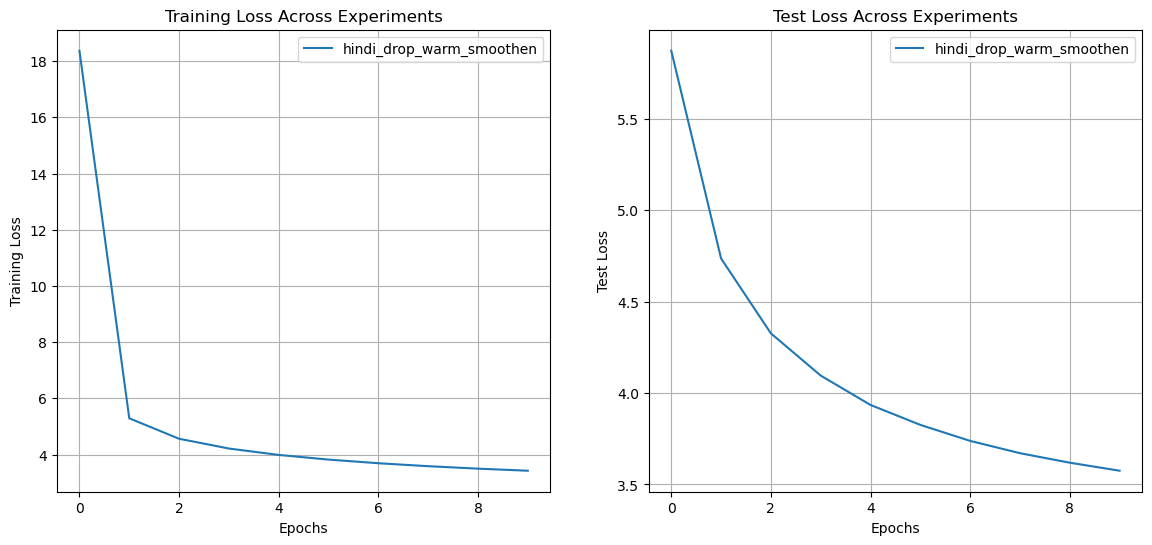

In [108]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot training losses
for exp_name, losses in train_losses.items():
    axes[0].plot(losses, label=exp_name)
axes[0].set_title("Training Loss Across Experiments")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Training Loss")
axes[0].legend()
# axes[0].set_yscale("log")
axes[0].grid(True)

# Plot test losses
for exp_name, losses in test_losses.items():
    axes[1].plot(losses, label=exp_name)
axes[1].set_title("Test Loss Across Experiments")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Test Loss")
axes[1].legend()
# axes[1].set_yscale("log")
axes[1].grid(True)

# Show the plots

In [137]:
def get_concatenated(files):
    train = [pd.read_csv(file + "_train_loss.txt", header=None) for file in files]
    test = [pd.read_csv(file + "_test_loss.txt", header=None) for file in files]
    return pd.concat(train, ignore_index=True), pd.concat(test, ignore_index=True)

## Attention Visualisation

In [18]:
from attention_visualisation import get_attention


In [19]:
batch = next(iter(inference_data))
attention_dicts = get_attention(model, batch)

NameError: name 'inference_data' is not defined

In [193]:
# attention_dict --> (batch x n_heads x seq_len x seq_len)

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

def process_and_visualise_attention(attentions, pixel_values, patch_size, threshold=0.6, raw_attn=False):    
    # Extract the CLS token attention (first token attending to all patches)    
    nh = attentions.shape[0]  # Number of attention heads
    attentions = attentions[:, 0, 1:].reshape(nh, -1)
    
    w_featmap = pixel_values.shape[-2] // patch_size
    h_featmap = pixel_values.shape[-1] // patch_size
    
    val, idx = torch.sort(attentions)  # Sort values per query
    val /= torch.sum(val, dim=1, keepdim=True)  # Normalize each col to sum to 1
    cumval = torch.cumsum(val, dim=1)  # Compute cumulative sum
    th_attn = cumval > (1 - threshold)  # Mask for top 'threshold' percentage
    idx2 = torch.argsort(idx)
    
    for head in range(nh):
        th_attn[head] = th_attn[head][idx2[head]]

    th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
    th_attn = nn.functional.interpolate(
        th_attn.unsqueeze(0), scale_factor=patch_size, mode="bicubic"
    )[0].cpu().detach().numpy()

    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(
        attentions.unsqueeze(0), scale_factor=patch_size, mode="bicubic"
    )[0].cpu().detach().numpy()

    image_np = pixel_values.permute(1, 2, 0).cpu().numpy()  # Shape: (H, W, C)
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())  # Normalize to [0,1]
    
    num_rows = 6 if raw_attn else 3  # Adjust number of rows based on raw_attn
    num_cols = 4  # Fixed number of columns
    figsize = (num_cols * 4, num_rows * 3)  # Adjust figure size dynamically

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=figsize)
    
    for head in range(12):  # Iterate over all heads
        row = head // num_cols  # Calculate row index
        col = head % num_cols   # Calculate column index
        
        ax = axes[row, col]
        ax.imshow(image_np)
        ax.imshow(th_attn[head], cmap="jet", alpha=0.4)
        ax.set_title(f"Head {head}")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()


torch.Size([20, 4, 140, 140])

## Metrics Calculations

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from metrics import corpus_bleu, sentence_bleu

In [11]:
original_sentence_1 = "प्रचीन काल में एक राजा के राज्य में एकादशी के दिन सभी लोग व्रत रखते थे।"
model_sentence_1 = "प्राचीन काल में, सभी लोग एकादशी के दिन में, एकादशी के दिन में प्रचार करते थे।"
sentence_bleu([original_sentence_1], model_sentence_1, generate_more=True)

generated 1 more sentences


0.3967088290836577

In [12]:
original_sentence = 'भारत-प्रशांत क्षेत्र में समुद्री स्वतंत्रता के लिए भारत-अमेरिका के आह्वान के संदर्भ में हुआ ने कहा कि समुद्र में सुरक्षा नौवहन के बारे में हम अंतरराष्ट्रीय कानून में उल्लेखित कानूनी अधिकारों को कायम रखेंगे और हम यह उम्मीद भी करते हैं कि नौवहन स्वतंत्रता के लिए पक्ष वास्तविक काम करें।' 
original_sentence_mod = "उन्होंने कहा कि भारत-ऑस्ट्रेलिया के बीच समुद्री सुरक्षा के संबंध में भारत और अमेरिका के बीच सहमति बनी है।"
model_sentence = 'भारत-अमेरिका के भारत-अमेरिका के लिए समुद्री स्वतंत्रता की अपील पर हुवा ने कहा, समुद्र में सुरक्षा नौवहन के बारे में हम अंतरराष्ट्रीय कानून में दायर कानूनी अधिकारों को बनाए रखते हैं और हम उम्मीद कर सकते हैं कि पक्ष ने भी सिंचाई की स्वतंत्रता सुनिश्चित करने के लिए वास्तविक चीजें कर सकते हैं।'
a = sentence_bleu([original_sentence, original_sentence_mod], model_sentence, generate_more=False)
b = corpus_bleu([[original_sentence, original_sentence_mod]], [model_sentence])

generated 1 more sentences


In [13]:
t1 = corpus_bleu([[original_sentence, original_sentence_mod]], [model_sentence], raw_values=True)
t2 = corpus_bleu([[original_sentence_1]], [model_sentence_1], raw_values=True)

In [20]:
new_num = t1[0] + t2[0]
new_denom = t1[1] + t2[1]
new_ref = t1[3] + t2[3]
new_cand = t1[2] + t2[2]

In [22]:
from metrics import brevity_penality

In [25]:
import numpy as np
bp = brevity_penality(new_cand, new_ref)
pn = [new_num[i] / new_denom[i] if new_denom[i] > 0 else 0 for i in range(1, 5)]
log_sum = sum([w * np.log(p) if p > 0 else 0 for w,p in zip((0.25, 0.25, 0.25, 0.25), pn)])
bp * np.exp(log_sum)


0.264586891307893

In [13]:
import json
import glob
import os
combined_data = []

# Construct a file pattern to search for JSON files in the input folder
json_files = glob.glob(os.path.join("../data/en-hi/", '*.json'))

for file in json_files:
    try:
        with open(file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            combined_data.extend(data)
            # print(data)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON from {file}: {e}")
    except Exception as e:
        print(f"An error occurred reading {file}: {e}")

# Write the combined data to the output file

with open("../data/en-hi/test.json", 'w') as f:
    json.dump(combined_data, f, indent=4)


In [16]:
corpus_bleu([[original_sentence, original_sentence_mod], [original_sentence_1]], [model_sentence, model_sentence_1])

0.264586891307893

In [ ]:
## Future Thoughts
# Build that visualiser for attention heads
# build some abalation pipeline ? 
# be able to run experiments keeping the number of total parameters constant but changing number of heads etc or should I keep
# change the variable while keeping the rest of the config params constant

In [17]:
original_sentence =  'देश में दो टीकों-कोवैक्सीन और सीरम इंस्टीट्यूट के कोविशील्ड को आपात उपयोग की मंजूरी मिली है।'
model_sentence = 'भारत ने देश में आपातकालीन उपयोग के लिए भारत बायोटेक और सेरम इंस्टीट्यूट ऑफ इंडिया के कोविशील्डड को दो टीके को मंजूरी दी है।'
sentence_bleu([original_sentence], model_sentence, generate_more=True)

generated 1 more sentences


0.43759047241829613

## Testing Scores

In [14]:
from collections import OrderedDict
checkpoint = torch.load("../papers/attention_is_all_you_need/Models/hindi_model_small_full_5/Model_230", map_location=torch.device("cpu"))
checkpoint['model_state_dict'] = OrderedDict((k.replace("module.", ""), v) for k, v in checkpoint['model_state_dict'].items())
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [147]:
import sentencepiece as spm
sp = spm.SentencePieceProcessor(model_file="../papers/attention_is_all_you_need/BPE/en-hi.model")
# model_prediction(model, None, config['SEQ_LEN'], device, sp.bos_id(), sp.eos_id(), sp.pad_id())

In [148]:
class LanguageTranslationDataset(Dataset):
    def __init__(self, seq_length, src_encodings, tgt_encodings, sos_token, eos_token, pad_token):
        super().__init__()
        self.paired_encodings = LanguageTranslationDataset.augment_encodings(src_encodings, tgt_encodings, sos_token, eos_token)
        self.seq_len = seq_length
        self.pad_token = pad_token

    @staticmethod
    def augment_encodings(src_encodings, tgt_encodings, sos_token, eos_token):
        src_encodings_app = [[sos_token] + sublist + [eos_token] for sublist in src_encodings]
        tgt_encodings_app = [[sos_token] + sublist for sublist in tgt_encodings]
        output_encodings = [sublist + [eos_token] for sublist in tgt_encodings] 
        full_encoding = list(zip(src_encodings_app, tgt_encodings_app, output_encodings))
        # full_encoding.sort(key=lambda x: len(x[0])) # sort sequence lengths
        return full_encoding


    def __getitem__(self, idx):
            src_seq, tgt_seq, output_seq = self.paired_encodings[idx]
            # print(src_seq)
            
            # Convert to tensors
            src_tensor = torch.tensor(src_seq, dtype=torch.long)
            tgt_tensor = torch.tensor(tgt_seq, dtype=torch.long)
            output_tensor = torch.tensor(output_seq, dtype=torch.long)

            # **Ensure the sequence length does not exceed `seq_len`**
            if src_tensor.size(0) > self.seq_len:
                src_tensor = src_tensor[:self.seq_len]  # Crop excess tokens
            if tgt_tensor.size(0) > self.seq_len:
                tgt_tensor = tgt_tensor[:self.seq_len]  # Crop excess tokens
            if output_tensor.size(0) > self.seq_len:
                output_tensor = output_tensor[:self.seq_len]  # Crop excess tokens

            # **Pad sequences to `seq_len` if they are shorter**
            src_tensor = F.pad(src_tensor, (0, max(0, self.seq_len - src_tensor.size(0))), value=self.pad_token)
            tgt_tensor = F.pad(tgt_tensor, (0, max(0, self.seq_len - tgt_tensor.size(0))), value=self.pad_token)
            output_tensor = F.pad(output_tensor, (0, max(0, self.seq_len - output_tensor.size(0))), value=self.pad_token)
            encoder_mask = (src_tensor != self.pad_token).int()
            subsequent_mask = torch.tril(torch.ones((self.seq_len, self.seq_len), dtype=torch.int))
            padding_mask = (tgt_tensor != self.pad_token).int()
            decoder_mask = subsequent_mask & padding_mask.unsqueeze(0)



            return {
                "src": src_tensor, # Seq_len
                "tgt": tgt_tensor, # seq_len
                "output": output_tensor, # seq_len
                "encoder_mask" : encoder_mask.unsqueeze(0).unsqueeze(0), # 1 x 1 x seq_len
                "decoder_mask" : decoder_mask.unsqueeze(0), # 1 x seq_len x seq_len
            }
    def __len__(self): 
            return len(self.paired_encodings)
        

In [149]:
import itertools
def get_data(datapath, ref_datapath, skiprows, amount, sp):
    english_sentences = pd.read_table(Path(datapath) /  "english_small.txt",  header=None, skiprows=skiprows, nrows=amount)
    hindi_sentences = pd.read_table(Path(datapath) /  "hindi_small.txt",  header=None, skiprows=skiprows, nrows=amount)

    english_encoded = sp.encode_as_ids(english_sentences.iloc[:, 0].to_list())
    with open(ref_datapath / "test.json", 'r') as f:
        ref_sentences = json.load(f)
    ref_sentences = ref_sentences[ : amount]
    encoding_hindi = list(itertools.chain.from_iterable(ref_sentences))
    # assert len(english_encoded) == len(ref_sentences)
    hindi_encoded = sp.encode_as_ids(encoding_hindi)[:amount]
    return english_encoded, hindi_encoded, ref_sentences, hindi_sentences

In [150]:
def get_dataloaders(sp, english_encoded, tgt_encoded, amount):
    full_data = LanguageTranslationDataset(seq_length=config['SEQ_LEN'], src_encodings=english_encoded, tgt_encodings=tgt_encoded, sos_token=sp.bos_id(), eos_token=sp.eos_id(),
                                        pad_token=sp.pad_id())
    dataloader = DataLoader(full_data, batch_size=amount, pin_memory=True, shuffle=False)
    return full_data, dataloader

In [151]:
def model_prediction(model, batch, max_len, device, sos_token, eos_token, pad_token):
    underlying_model = model.module if hasattr(model, 'module') else model

    encoder_input = batch['src'].to(device)  # B x seq_len
    encoder_mask = batch['encoder_mask'].to(device)  # B x 1 x 1 x seq_len
    encoder_output = underlying_model.encode(encoder_input, encoder_mask)

    B = encoder_input.size(0)
    decoder_input = torch.full((B, max_len), pad_token).to(device)
    decoder_input[:, 0] = sos_token
    finished = torch.zeros(B, dtype=torch.bool, device=device)

    for t in range(max_len - 1):
        subsequent_mask = torch.tril(torch.ones((max_len, max_len), dtype=torch.int)).expand(B, -1, -1).to(device)
        other_mask = (decoder_input != pad_token).int().unsqueeze(1)
        decoder_mask = (subsequent_mask & other_mask).unsqueeze(1).to(device)
        out = underlying_model.decode(decoder_input, encoder_output, encoder_mask, decoder_mask)
        prediction = underlying_model.proj(out)  # shape: (B, max_len, vocab_size)
        next_tokens = torch.argmax(prediction[:, t, :], dim=-1)
        next_tokens = torch.where(finished, pad_token, next_tokens)
        decoder_input[:, t + 1] = next_tokens
        finished |= (next_tokens == eos_token)
        if finished.all():
            break

    return decoder_input

In [152]:
import json
english_encoded, hindi_encoded, ref_sentences, hindi_sentences = get_data(Path("../data/en-hi/"), Path("../data/en-hi/"), skiprows=550_000, amount=256, sp=sp)

In [153]:
test, dataloader = get_dataloaders(sp, english_encoded, hindi_encoded, 32)

In [154]:
ref_sentences = hindi_sentences.iloc[:, 0].tolist()

In [155]:
from collections import Counter
num_c = Counter({1: 0, 2: 0, 3: 0, 4:0})
denom_c = Counter({1: 0, 2: 0, 3: 0, 4:0})
ref_len = 0
cand_len = 0
for idx, batch in tqdm(enumerate(dataloader)):
    pred = model_prediction(model, batch, 140, "cpu", sp.bos_id(), sp.eos_id(), sp.pad_id())
    decoded = sp.decode(pred.detach().cpu().tolist())
    val1, val2, val3, val4 = corpus_bleu(ref_sentences[(idx) * 32: (idx + 1) * 32], decoded, raw_values=True)
    # break
    num_c += val1
    denom_c += val2
    cand_len += val3
    ref_len += val4
    break

0it [00:27, ?it/s]


NameError: name 'corpus_bleu' is not defined

In [154]:
from metrics import brevity_penality
import numpy as np
bp = brevity_penality(cand_len, ref_len)
pn = [num_c[i] / denom_c[i] if denom_c[i] > 0 else 0 for i in range(1, 5)]
log_sum = sum([w * np.log(p) if p > 0 else 0 for w,p in zip((0.25, 0.25, 0.25, 0.25), pn)])
bp * np.exp(log_sum)

0.48096358779693094

## Attention Visualiser


In [38]:
from collections import OrderedDict
checkpoint = torch.load("../papers/attention_is_all_you_need/Models/hindi_model_4_256_2048_2_2/Model_300", map_location=torch.device("cpu"))
checkpoint['model_state_dict'] = OrderedDict((k.replace("module.", ""), v) for k, v in checkpoint['model_state_dict'].items())
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [81]:
from papers.attention_is_all_you_need.TransformerComponents.AttentionHead import MultiHeadAttention

attention_values_dict = {}
query_dict = {}
keys_dict = {}
def attention_hook(module, input, output, name):
    attention_values_dict[name] = module.attention_scores
    query_dict[name] = module.queries
    keys_dict[name] = module.keys

hooks = []

for name, module in model.named_modules():
    if isinstance(module, MultiHeadAttention):
        def get_hook(hook_name):
            return lambda m, i, o: attention_hook(m, i, o, hook_name)
        
        # Register the hook with properly bound name
        hook = module.register_forward_hook(get_hook(name))
        hooks.append(hook)


In [82]:
import sentencepiece as spm
sp = spm.SentencePieceProcessor(model_file="../papers/attention_is_all_you_need/BPE/en-hi.model")

def get_padded_sentence(english_sentence, sp, seq_len = 140):
    english_encoded = sp.Encode(english_sentence)    
    src_encodings = [sp.bos_id()] + english_encoded + [sp.eos_id()]
    tgt_encodings = [sp.pad_id()] * seq_len
    src_tensor = torch.tensor(src_encodings, dtype=torch.long)
    tgt_tensor = torch.tensor(tgt_encodings, dtype=torch.long)

    if src_tensor.size(0) > seq_len:
        src_tensor = src_tensor[:seq_len]  # Crop excess tokens
    if tgt_tensor.size(0) > seq_len:
        tgt_tensor = tgt_tensor[:seq_len]  # Crop excess tokens

    src_tensor = F.pad(src_tensor, (0, max(0, seq_len - src_tensor.size(0))), value=sp.pad_id())
    encoder_mask = (src_tensor != sp.pad_id()).int()
    subsequent_mask = torch.tril(torch.ones((seq_len, seq_len), dtype=torch.int))
    padding_mask = (tgt_tensor != sp.pad_id()).int()
    decoder_mask = subsequent_mask & padding_mask.unsqueeze(0)

    return {
        "src": src_tensor.unsqueeze(0), # Seq_len
        "tgt": tgt_tensor.unsqueeze(0), # seq_len
        "encoder_mask" : encoder_mask.unsqueeze(0).unsqueeze(0).unsqueeze(0), # 1 x 1 x 1 x seq_len
        "decoder_mask" : decoder_mask.unsqueeze(0).unsqueeze(0), # 1 x  1 x seq_len x seq_len
    }

In [41]:
def model_prediction(model, batch, max_len, device, sos_token, eos_token, pad_token, method='greedy', k=3, V=100, alpha=0.6):
    underlying_model = model.module if hasattr(model, 'module') else model
    if method == 'greedy':
        encoder_input = batch['src'].to(device)  # B x seq_len
        encoder_mask = batch['encoder_mask'].to(device)  # B x 1 x 1 x seq_len
        encoder_mask[:, 0].zero_() # head 0 encoder mask is 0
        encoder_output = underlying_model.encode(encoder_input, encoder_mask)

        B = encoder_input.size(0)
        decoder_input = torch.full((B, max_len), pad_token).to(device)
        decoder_input[:, 0] = sos_token
        finished = torch.zeros(B, dtype=torch.bool, device=device)
        subsequent_mask = torch.tril(torch.ones((max_len, max_len), dtype=torch.int)).expand(B, -1, -1).to(device)

        for t in range(max_len - 1):
            other_mask = (decoder_input != pad_token).int().unsqueeze(1)
            decoder_mask = (subsequent_mask & other_mask).unsqueeze(1).to(device)
            out = underlying_model.decode(decoder_input, encoder_output, encoder_mask, decoder_mask)
            prediction = underlying_model.proj(out)  # shape: (B, max_len, vocab_size)
            next_tokens = torch.argmax(prediction[:, t, :], dim=-1)
            next_tokens = torch.where(finished, pad_token, next_tokens)
            decoder_input[:, t + 1] = next_tokens
            finished |= (next_tokens == eos_token)
            if finished.all():
                break
        return decoder_input
    
    elif method == 'beam_search':
        encoder_input = batch['src'].to(device)  # 1 x seq_len
        encoder_mask = batch['encoder_mask'].to(device)  # 1 x 1 x 1 x seq_len
        encoder_output = underlying_model.encode(encoder_input, encoder_mask)
        decoder_input = torch.full((k, max_len), pad_token, dtype=torch.long, device=device)
        decoder_input[:, 0] = sos_token
        
        scores = torch.zeros(k, device=device)
        finished = torch.zeros(k, dtype=torch.bool, device=device)
        
        completed_sequences = []
        completed_scores = []
        
        subsequent_mask = torch.tril(
            torch.ones((max_len, max_len), device=device, dtype=torch.uint8)
        ).unsqueeze(0).unsqueeze(0)  # shape: (1, 1, max_len, max_len)
        
        beam_encoder_output = encoder_output.expand(k, -1, -1)
        beam_src_mask = encoder_mask.expand(k, -1, -1, -1)
        
        for t in range(max_len - 1):
            if finished.all():
                break
                
            pad_mask = (decoder_input != pad_token).unsqueeze(1).unsqueeze(1)
            decoder_mask = subsequent_mask & pad_mask
            out = model.decode(decoder_input, beam_encoder_output, beam_src_mask, decoder_mask)
            logits = model.proj(out)  # shape: (beam_size, max_len, vocab_size)
            log_probs = F.log_softmax(logits[:, t, :], dim=-1)  # shape: (beam_size, vocab_size)
            all_candidates = []
            for beam_idx in range(k):
                if finished[beam_idx]:
                    continue
                    
                top_v_logprobs, top_v_indices = log_probs[beam_idx, :].topk(V)
                for v_idx in range(V):
                    token = top_v_indices[v_idx].item()
                    logprob = top_v_logprobs[v_idx].item()
                    new_score = scores[beam_idx] + logprob
                    
                    # Current length is t+1 (+1 for the token we're adding)
                    seq_len = t + 2  # +1 for current position, +1 for 0-indexing
                    normalised_score = new_score / (seq_len ** alpha)
                    all_candidates.append((beam_idx, token, normalised_score, new_score))
            
            if not all_candidates:
                break
            all_candidates.sort(key=lambda x: x[2], reverse=True)
            
            next_decoder_input = torch.full((k, max_len), pad_token, dtype=torch.long, device=device)
            next_scores = torch.zeros(k, device=device)
            next_finished = torch.zeros(k, dtype=torch.bool, device=device)
            
            for new_idx, (old_beam_idx, token, _, raw_score) in enumerate(all_candidates[:k]):
                next_decoder_input[new_idx] = decoder_input[old_beam_idx].clone()
                next_decoder_input[new_idx, t+1] = token
                next_scores[new_idx] = raw_score
                if token == eos_token:
                    next_finished[new_idx] = True
                    
                    completed_sequences.append(next_decoder_input[new_idx].clone())
                    completed_scores.append(raw_score / ((t+2) ** alpha)) 
                elif next_finished[new_idx]:
                    completed_sequences.append(next_decoder_input[new_idx].clone())
                    completed_scores.append(raw_score / ((t+2) ** alpha))
            
            decoder_input = next_decoder_input
            scores = next_scores
            finished = next_finished
        
        for beam_idx in range(k):
            if not finished[beam_idx]:
                completed_sequences.append(decoder_input[beam_idx].clone())
                completed_scores.append(scores[beam_idx] / (max_len ** alpha))
        
        if completed_sequences:
            best_idx = torch.tensor(completed_scores, device=device).argmax().item()
            return completed_sequences[best_idx].unsqueeze(0)
        else:
            # If no completed sequences (shouldn't happen), return best from current beam
            best_idx = scores.argmax().item()
            return decoder_input[best_idx].unsqueeze(0)  # Add batch dimension


In [89]:
class AttentionScoreHook:
    def __init__(self, model):
        self.model = model
        self.attention_scores = []
        self.queries = []
        self.keys = []
        self.hook_handles = []
        self.layer_count = 0
        
        self._register_hooks()
    
    def _make_hook(self, layer_idx):
        def hook(module, input, output):
            if hasattr(module, 'attention_scores'):
                self.attention_scores.append((layer_idx, module.attention_scores.detach().cpu().clone()))
                self.queries.append((layer_idx, module.queries.detach().cpu().clone()))
                self.keys.append((layer_idx, module.keys.detach().cpu().clone()))
        return hook
    
    def _register_hooks(self):
        """Register hooks on all MultiHeadAttention modules"""
        layer_idx = 0
        
        for encoder_layer in self.model.encoder.layers:
            handle = encoder_layer.attention.register_forward_hook(
                self._make_hook(layer_idx)
            )
            self.hook_handles.append(handle)
            layer_idx += 1
            self.layer_count += 1
        
        for decoder_layer in self.model.decoder.layers:
            # Self-attention
            handle = decoder_layer.attention.register_forward_hook(
                self._make_hook(layer_idx)
            )
            self.hook_handles.append(handle)
            layer_idx += 1
            self.layer_count += 1
            
            # Cross-attention
            handle = decoder_layer.attention_2.register_forward_hook(
                self._make_hook(layer_idx)
            )
            self.hook_handles.append(handle)
            layer_idx += 1
            self.layer_count += 1
    
    def get_attention_scores(self):
        """
        Get attention scores as [num_layers, num_heads, seq_len, seq_len]
        
        Args:
            batch_idx: Which batch item to extract (default: 0)
            
        Returns:
            Tensor of shape [num_layers, num_heads, seq_len, seq_len]
        """

        sorted_scores = sorted(self.attention_scores, key=lambda x: x[0])
        sorted_queries = sorted(self.queries, key=lambda x: x[0])
        sorted_keys = sorted(self.keys, key=lambda x: x[0])
        results = []
        for sorted_tensor in [sorted_scores, sorted_queries, sorted_keys]:
            tensors = [score for _, score in sorted_tensor]
            stacked = torch.stack(tensors, dim=0)  # [num_layers, batch, heads, seq_len, seq_len]
            result = stacked[:, 0].numpy()  # [num_layers, heads, seq_len, seq_len]
            results.append(result)
        
        self.attention_scores = []
        self.keys = []
        self.queries = []
        return results[0], results[1], results[2]
    
    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()
        self.hook_handles = []

def extract_attention_weights(model, src, tgt, src_mask=None, tgt_mask=None):
    hook = AttentionScoreHook(model)
    with torch.no_grad():
        model(src, tgt, src_mask, tgt_mask)
    attention_weights, queries, keys = hook.get_attention_scores()
    hook.remove_hooks()
    return attention_weights, queries, keys

In [90]:
def reorder_attention_values(attention_values, n_encoders):
    return {
        'encoder_attention' : attention_values[:n_encoders, ...],
        'decoder_self_attention' : attention_values[n_encoders::2, ...],
        'decoder_cross_attention' : attention_values[n_encoders + 1::2, ...]
    }

In [91]:
def get_token_until_eos(tokens):
    if '<EOS>' in tokens:
        eos_idx = tokens.index('<EOS>')
        return tokens[: eos_idx + 1]
    else:
        return tokens

In [456]:
converted_sentence = get_padded_sentence("He must have gone in that room.", sp)
pred = model_prediction(model, converted_sentence, 140, "cpu", sp.bos_id(), sp.eos_id(), sp.pad_id())
# beam_search_best = model_prediction(model, converted_sentence, 140, "cpu", sp.bos_id(), sp.eos_id(), sp.pad_id(), method='beam_search', k=3, V = 500)
split_encoded = sp.id_to_piece(converted_sentence['src'][0].tolist())
split_decoded = sp.id_to_piece(pred.detach().cpu().tolist()[0])
subsequent_mask = torch.tril(torch.ones((140, 140), dtype=torch.int))
padding_mask = (pred != sp.pad_id()).int()
decoder_mask = subsequent_mask & padding_mask
attention_vals, query_vals, keys_vals = extract_attention_weights(model, converted_sentence['src'], pred, converted_sentence['encoder_mask'], decoder_mask.unsqueeze(0))
# organised_weights = reorder_attention_values(attention_vals, 2)
split_encoded_trim = get_token_until_eos(split_encoded)
split_decoded_trim = get_token_until_eos(split_decoded)

In [457]:
sp.Decode(pred.detach().cpu().tolist()[0])

'वह उस कमरे में जाना चाहिए था।'

In [477]:
run_attention_dashboard(attention_vals, split_encoded_trim, split_decoded_trim, colormap='Viridis')

In [96]:
run_model_dashboard(attention_vals, split_encoded_trim, split_decoded_trim)

In [491]:
from attention_visualisation import run_neuron_dashboard
raw_attention = query_vals @ keys_vals.transpose(0, 1, 3, 2)
run_neuron_dashboard(raw_attention, attention_vals, query_vals, keys_vals, split_encoded_trim,  split_decoded_trim)

## Ablation Studies

In [492]:
model

Transformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0-1): 2 x EncoderBlock(
        (attention): MultiHeadAttention(
          (w_q): Linear(in_features=256, out_features=256, bias=False)
          (w_k): Linear(in_features=256, out_features=256, bias=False)
          (w_v): Linear(in_features=256, out_features=256, bias=False)
          (w_o): Linear(in_features=256, out_features=256, bias=False)
        )
        (ff): PositionWiseFFN(
          (linear_1): Linear(in_features=256, out_features=2048, bias=True)
          (linear_2): Linear(in_features=2048, out_features=256, bias=True)
        )
        (residuals): ModuleList(
          (0-1): 2 x ResidualConnection(
            (norm): LayerNormalisation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0-1): 2 x DecoderBlock(
        (attention): MultiHeadAttention(
          (w_q): Linear(in_features=256, out_feature